**2D nonlinear diffusion-reaction system**

In [171]:
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from sys import stderr
from scipy import stats
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import griddata
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader

seed = 42
batch_size = 100

np.random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(4, 4)})

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1
        self.w_param_std = 1
        self.numInputs = 2
        self.numParams = 1
        self.numOutputs = 2
        self.hidden_size = 25

        # Initialize history variables
        self.total_loss_history = []
        self.loss_interior_history = []
        self.loss_data_history = []
        self.loss_bc_history = []
        self.loss_std_history = []

        self.x0 = torch.tensor([1.0], requires_grad=True).to(self.device)
        self.y0 = torch.tensor([1.0], requires_grad=True).to(self.device)

        # self.predicted_params = torch.zeros((self.numParams,1), requires_grad=True, device=self.device)
        self.predicted_params = torch.zeros((batch_size,1), requires_grad=True, device=self.device)

        # We have 2 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(self.device)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(self.device)


#     # make this static so that it can be called independently
#     @staticmethod
#     def exact_solution(t, x):
#         return torch.exp(-t) * torch.sin(torch.pi * x)


    def forward(self, x, y):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x).float().to(self.device)
        
        if not torch.is_tensor(y):
            y = torch.from_numpy(y).float().to(self.device)

        input = torch.cat((x, y), 1)
        h1 = torch.tanh(self.b1(input))
        h2 = torch.tanh(self.b2(h1))

        # prior_param_sample = torch.rand(1, 1, device=self.device).requires_grad_(True)
        prior_param_sample = torch.rand(batch_size, self.hidden_size , device=self.device).requires_grad_(True)

        t1 = torch.tanh(self.t1(prior_param_sample))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_sample = self.t3(t2)
        self.predicted_params = posterior_param_sample

        u = self.b3(torch.multiply(t2, h2))

        return u


    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]
        return self.compute_derivative(dy_dx, x, n - 1)



    def PDE_residual(self, x, y):
        u = self.forward(x, y)
        du_dx = self.compute_derivative(u, x, 1)
        du_dy = self.compute_derivative(u, y, 1)
        d2u_dx2 = self.compute_derivative(u, x, 2)
        d2u_dy2 = self.compute_derivative(u, y, 2)

        residual =  dy_dt - torch.multiply(self.predicted_params[:,[0]], d2y_dx2) \
            + torch.exp(- self.predicted_params[:,[1]] * t) * (torch.sin(torch.tensor(np.pi) * x) - torch.tensor(np.pi) ** 2 * torch.sin(torch.tensor(np.pi) * x))
        return residual


    def loss_boundary_condition(self, num_samples=100):
        x_low = -1
        x_high = 1
        xb_low   = x_low * torch.ones((num_samples, 1),  device = self.device)
        xb_high  = x_high * torch.ones((num_samples, 1), device = self.device)

        t = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True) - 1.0

        yb_low = self.exact_solution(t, xb_low)
        yb_high = self.exact_solution(t, xb_high)

        yb_pred_low = self.forward(t, xb_low)
        yb_pred_high = self.forward(t, xb_high)

        loss_ic = torch.mean(torch.square(yb_pred_low - yb_low)) \
                + torch.mean(torch.square(yb_pred_high - yb_high))
        return loss_ic


    def compute_losses(self):
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        loss_bc = self.loss_boundary_condition()
        return loss_ic, loss_interior, loss_data, loss_bc


    def loss_data(self, num_samples=100):
        t_data, x_data, y_data = next(iter(train_loader))
        y_pred = self.forward(t_data, x_data)
        loss = torch.mean(torch.square(y_pred - y_data))
        return loss


    def loss_interior(self, num_samples=100):
        interior_t_samples = torch.rand((num_samples, 1),   device=self.device).requires_grad_(True)
        interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        res = self.PDE_residual(interior_t_samples, interior_x_samples)
        loss_residual = torch.mean(torch.square(res))
        return loss_residual


    def sample_parameter_posterior(self, num_samples=100):
        prior_param_samples = torch.rand(num_samples, self.hidden_size, device=self.device).requires_grad_(True)
        t1 = torch.tanh(self.t1(prior_param_samples))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_samples = self.t3(t2)
        return posterior_param_samples


    def update_predicted_params(self, posterior_samples):
        mean = torch.mean(posterior_samples, dim=0)  # Compute the mean along the first axis
        std = torch.std(posterior_samples, dim=0)    # Compute the standard deviation along the first axis

        self.predicted_params = posterior_samples
        self.mean_predicted_params = mean  # Store the mean
        self.std_params = std  # Attach the standard deviation as an attribute


    def closure(self):
        self.optimizer.zero_grad()
        loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
        total_loss = self.w_int * loss_interior \
                   + self.w_data * loss_data \
                   + self.w_bc * loss_bc

        # Sample the parameter posterior and update self.predicted_params and self.std_params
        posterior_samples = self.sample_parameter_posterior(num_samples=100)
        self.update_predicted_params(posterior_samples)

        # Add the (Log(std))**2 term to the loss with the specified weight
        self.log_std_squared_loss = self.w_param_std * torch.mean(torch.log(self.std_params)**2)
        total_loss += self.log_std_squared_loss

        total_loss.backward(retain_graph=True)
        return total_loss


    def train(self, epochs, optimizer='Adam', num_samples=100, **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=3, verbose=True)


        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)
            if epoch % 1000 == 0:
                loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_ic + loss_interior + loss_data + loss_bc

                scheduler.step(total_loss)

                # Append losses to history
                self.total_loss_history.append(total_loss.item())
                self.loss_ic_history.append(loss_ic.item())
                self.loss_interior_history.append(loss_interior.item())
                self.loss_data_history.append(loss_data.item())
                self.loss_bc_history.append(loss_bc.item())
                self.loss_std_history.append(self.log_std_squared_loss.item())

                print(f'Epoch({optimizer}):{epoch},  Total Loss:{total_loss.item():.2f}  ' \
                        f'PDE Loss:{loss_interior.item():.2f}  ' \
                        f'BC Loss:{loss_bc.item():.2f}  ' \
                        f'IC Loss: {loss_ic.item():.2f}  ' \
                        # f'Predicted Param:{self.predicted_params.detach().cpu().numpy()[0][0]:.2f}'
                        f'Mean Predicted Param 1: {self.mean_predicted_params[0]:.2f} ' \
                        f'Mean Predicted Param 2: {self.mean_predicted_params[1]:.2f} ' \
                        f'Std Params:{self.std_params.detach().cpu().numpy()[0]:.2f}  ' \
                        f'Std Log Loss:{self.log_std_squared_loss.item():.2f}')

In [172]:
# exact solution
def exact_solution(x, y):
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

# function f
def source_term(x, y, lambd=0.01, k=1.0):
    u = exact_solution(x, y)
    f = -1/50.0 * torch.pi**2 * (u) + u**2
    return f


In [173]:
def sample_dataset_nonlinear(noise_scale=0.01, num_samples=100, device='cpu', lambd=0.01, k=0.5):
    x = torch.linspace(-1, 1, num_samples, device=device) # Space domain for x
    y = torch.linspace(-1, 1, num_samples, device=device) # Space domain for y

    # Create a 2D grid of x and y values
    x_grid, y_grid = torch.meshgrid(x, y, indexing="ij")

    u = exact_solution(x_grid, y_grid)
    f = source_term(x_grid, y_grid)

    return x_grid, y_grid, u, f

In [178]:
def create_train_dataset():
    # Generate the data
    x, y, u, f = sample_dataset_nonlinear(num_samples=100)
    
    # Generate random sensor locations
    num_sensors = 100
    sensor_x = np.random.uniform(-1, 1, num_sensors)
    sensor_y = np.random.uniform(-1, 1, num_sensors)
    
    #plot u and f
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # First subplot for 'u'
    contour1 = axes[0].contourf(x.numpy(), y.numpy(), u.numpy(), cmap='jet', levels=50, vmin=-1, vmax=1)
    scatter_u = axes[0].scatter(sensor_x, sensor_y, facecolors='none', marker='o', edgecolor='black', s=40, linewidths=2, label="training sample for u") 
    fig.colorbar(contour1, ax=axes[0])
    axes[0].set_title('Distribution of u')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)

    # Second subplot for 'f'
    contour2 = axes[1].contourf(x.numpy(), y.numpy(), f.numpy(), cmap='jet', levels=50, vmin=0, vmax=1)
    scatter_f = axes[1].scatter(sensor_x, sensor_y, color='black', marker='x', s=40, linewidths=2, label="training sample for s")
    fig.colorbar(contour2, ax=axes[1])
    axes[1].set_title('Distribution of f')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)

    plt.tight_layout() 
    plt.show()

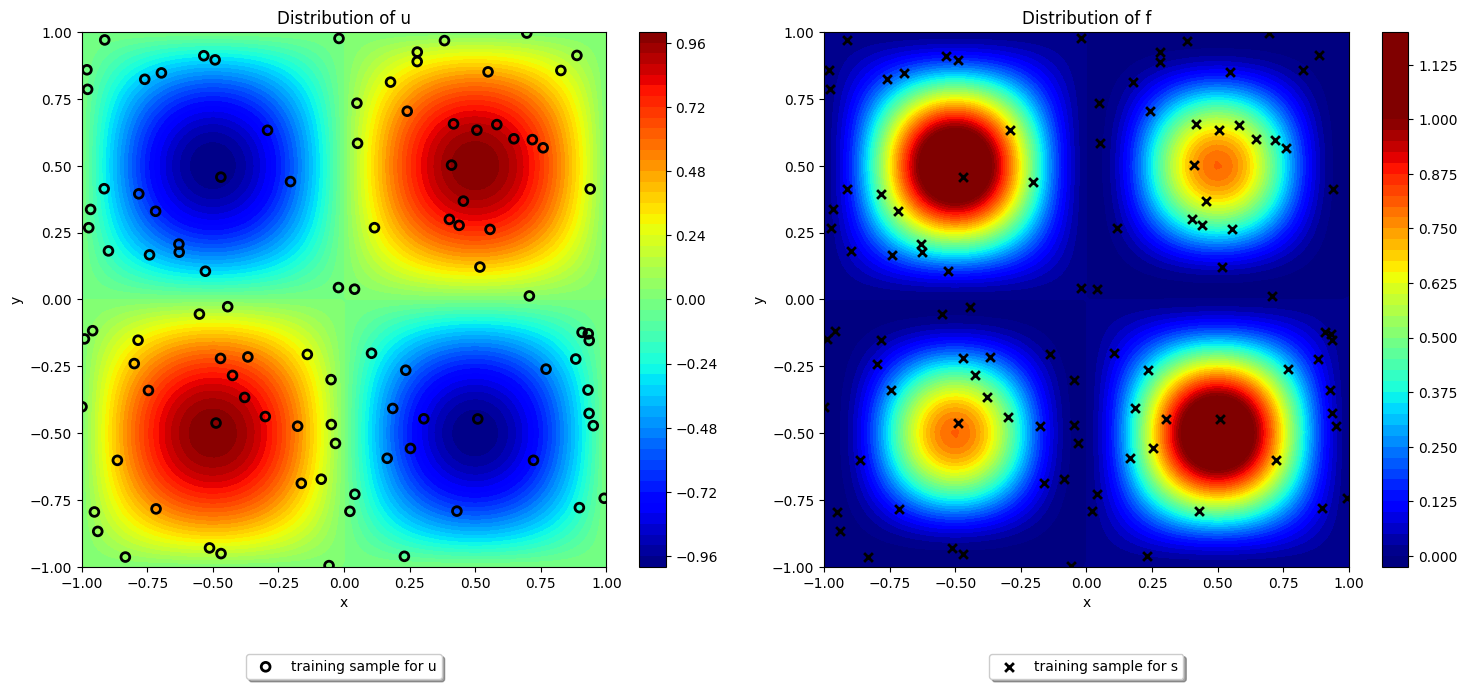

In [179]:
create_train_dataset()